In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import GradScaler, autocast

import cv2

import albumentations
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score

from tqdm import tqdm
import argparse
import os, sys, yaml

sys.path.append('/workspace/siim-rsna-2021')
from src.logger import setup_logger, LOGGER
from src.meter import mAPMeter, AUCMeter, APMeter, AverageValueMeter
from src.utils import plot_sample_images
from src.segloss import SymmetricLovaszLoss

# import neptune.new as neptune
import wandb
import pydicom

import time
from contextlib import contextmanager

import timm

import warnings

In [2]:
def seed_torch(seed=516):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


In [9]:
# =============================================================================
# Model
# =============================================================================

import segmentation_models_pytorch as smp


class Net(nn.Module):
    def __init__(self, name="resnest101e"):
        super(Net, self).__init__()
        self.model = smp.Unet(
            encoder_name=name,  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
            in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=1,  # model output channels (number of classes in your dataset)
            activation=None
        )


    def forward(self, x):
        x = self.model(x)
        return x

# =============================================================================
# Dataset
# =============================================================================

class CustomDataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 transform=None,
                 mode="train",
                 ):

        self.df = df
        self.image_size = image_size
        self.transform = albumentations.Compose([
                albumentations.Resize(image_size, image_size),
        ])


        self.mode = mode

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]

        images = cv2.imread(row.npy_path)

        aug = self.transform(image=images)                
        images_only = aug['image'].astype(np.float32).transpose(2, 0, 1) / 255                

        return {
            "image": torch.tensor(images_only, dtype=torch.float),
            "img_path": row.npy_path,
        }

# save mask

In [36]:
save_dir_path = "/workspace/data/lung_mask/"

In [26]:
warnings.simplefilter('ignore')

yaml_path = "config.yaml"
if os.path.isfile(yaml_path):
    with open(yaml_path) as file:
        cfg = yaml.safe_load(file.read())
else:
    print('Error: No such yaml file')
    sys.exit()
# seed_everythin
seed_torch()

# output
exp_name = cfg["exp_name"]  # os.path.splitext(os.path.basename(__file__))[0]
output_path = os.path.join("/workspace/output", exp_name)

# params
device_id = cfg["device_id"]
device = "cuda:{}".format(device_id) if torch.cuda.is_available() else "cpu"

#######################################
## params
#######################################
model_name = cfg["model_name"]
img_size = cfg["img_size"]
batch_size = cfg["batch_size"]
n_workers = cfg["n_workers"]
n_epochs = cfg["n_epochs"]
start_epoch = cfg["start_epoch"]
transform = cfg["transform"]
hold_out = cfg["hold_out"]
accumulation_steps = cfg["accumulation_steps"]
early_stopping_steps = cfg["early_stopping_steps"]
freeze_bn = cfg["freeze_bn"]

use_amp = cfg["use_amp"]
use_npy = cfg["use_npy"]

clahe = cfg["clahe"]
mix = cfg["mix"]

use_bbox = cfg["use_bbox"]

#######################################
## CV
#######################################
df = pd.read_csv("/workspace/data/df_train_study_level_npy640_3_w_bbox_hw.csv").groupby('image_id').first()

# ==== INIT MODEL
device = torch.device(device)
model = Net(model_name).to(device)

# load weight
load_checkpoint = "/workspace/output/seg_exp001/model/cv0_weight_checkpoint_best.pth"
weight = torch.load(load_checkpoint, map_location=device)
model.load_state_dict(weight["state_dict"])

<All keys matched successfully>

In [68]:
kernel = np.ones((10,10),np.uint8)
# kernel = np.ones((5,5),np.uint8)
def morphology(img):
    img = cv2.erode(img,kernel,iterations = 2)
    img = cv2.dilate(img,kernel,iterations = 3)
    return img

def get_bbox_from_mask(mask, padding=10):
    # lung crop
    mask = (mask > 0.5) * 1
    x0x1 = np.where(mask.max(0) == 1)[0]
    y0y1 = np.where(mask.max(1) == 1)[0]
    x0 = np.max([x0x1[0] - padding, 0])
    x1 = np.min([x0x1[-1] + padding, mask.shape[1]])
    y0 = np.max([y0y1[0] - padding, 0])
    y1 = np.min([y0y1[-1] + padding, mask.shape[0]])
    return x0, y0, x1, y1

In [81]:
val_dataset = CustomDataset(df=df, image_size=img_size, mode="val")
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                            pin_memory=False, num_workers=n_workers, drop_last=False)

# Save info

img_path_list = []
mask_path_list = []
x0_list = []
y0_list = []
x1_list = []
y1_list = []

# ======================================================================
# Prediction
# ======================================================================
progress_bar = tqdm(val_dataloader)

model.eval()
torch.set_grad_enabled(False)

for step_val, data in enumerate(progress_bar):
#     if step_val == 1:
#         break
    inputs = data["image"].to(device)
    img_path = data["img_path"]
    output = model(inputs)
    pred = (output.sigmoid().detach().cpu().numpy() > 0.65) * 1
    for path, pred_mask in zip(img_path, pred):
        img_name = path.split('/')[-1]
        save_path = save_dir_path + img_name
        mask = morphology((pred_mask[0]* 255).astype(np.uint8))
        cv2.imwrite(save_path, mask)
        
        x0, y0, x1, y1 = get_bbox_from_mask(mask)
        
        img_path_list += [path]
        mask_path_list += [save_path]
        x0_list += [x0]
        y0_list += [y0]
        x1_list += [x1]
        y1_list += [y1]

100%|██████████| 383/383 [00:53<00:00,  7.14it/s]


In [82]:
df_info = pd.DataFrame({
    "img_path": img_path_list,
    "mask_path": mask_path_list,
    "x0": x0_list,
    "y0": y0_list,
    "x1": x1_list,
    "y1": y1_list,
})

In [83]:
print(df_info.shape)
df_info.head()

(6117, 6)


,img_path,mask_path,x0,y0,x1,y1
0,/workspace/data/train_640_2/000a312787f2.png,/workspace/data/lung_mask/000a312787f2.png,60,80,430,382
1,/workspace/data/train_640_2/000c3a3f293f.png,/workspace/data/lung_mask/000c3a3f293f.png,62,0,512,407
2,/workspace/data/train_640_2/0012ff7358bc.png,/workspace/data/lung_mask/0012ff7358bc.png,101,11,429,359
3,/workspace/data/train_640_2/001398f4ff4f.png,/workspace/data/lung_mask/001398f4ff4f.png,84,35,458,432
4,/workspace/data/train_640_2/001bd15d1891.png,/workspace/data/lung_mask/001bd15d1891.png,97,27,512,400


In [84]:
df_save = pd.read_csv("/workspace/data/df_train_study_level_npy640_3_w_bbox_hw.csv")

In [85]:
df_save.merge(df_info, left_on="npy_path", right_on="img_path", how="left")

,id,x,y,w,h,study_id,image_id,have_box,dicom_path,Negative for Pneumonia,...,npy_path,is_none,height,width,img_path,mask_path,x0,y0,x1,y1
0,04f41a8958f7_image,688.06282,966.82563,518.48212,1130.17438,6e4a0581cefe,04f41a8958f7,1,/workspace/data/train/6e4a0581cefe/018ed20fa9c...,0,...,/workspace/data/train_640_2/04f41a8958f7.png,0,2490,3408,/workspace/data/train_640_2/04f41a8958f7.png,/workspace/data/lung_mask/04f41a8958f7.png,88,103,487,512
1,04f41a8958f7_image,2482.36026,1636.77436,652.47168,652.47168,6e4a0581cefe,04f41a8958f7,1,/workspace/data/train/6e4a0581cefe/018ed20fa9c...,0,...,/workspace/data/train_640_2/04f41a8958f7.png,0,2490,3408,/workspace/data/train_640_2/04f41a8958f7.png,/workspace/data/lung_mask/04f41a8958f7.png,88,103,487,512
2,04f41a8958f7_image,1235.67308,1628.03597,509.74353,559.26147,6e4a0581cefe,04f41a8958f7,1,/workspace/data/train/6e4a0581cefe/018ed20fa9c...,0,...,/workspace/data/train_640_2/04f41a8958f7.png,0,2490,3408,/workspace/data/train_640_2/04f41a8958f7.png,/workspace/data/lung_mask/04f41a8958f7.png,88,103,487,512
3,0572ef0d0c1a_image,1818.65264,233.50598,613.04395,839.53784,adbfed2da701,0572ef0d0c1a,1,/workspace/data/train/adbfed2da701/e2fa197720c...,0,...,/workspace/data/train_640_2/0572ef0d0c1a.png,0,2436,3032,/workspace/data/train_640_2/0572ef0d0c1a.png,/workspace/data/lung_mask/0572ef0d0c1a.png,81,0,440,230
4,0572ef0d0c1a_image,598.60492,61.37052,688.54175,881.81674,adbfed2da701,0572ef0d0c1a,1,/workspace/data/train/adbfed2da701/e2fa197720c...,0,...,/workspace/data/train_640_2/0572ef0d0c1a.png,0,2436,3032,/workspace/data/train_640_2/0572ef0d0c1a.png,/workspace/data/lung_mask/0572ef0d0c1a.png,81,0,440,230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9671,ffd9b6cf2961_image,707.25199,722.07926,392.14044,849.18683,7eed9af03814,ffd9b6cf2961,1,/workspace/data/train/7eed9af03814/668a64e3a5f...,0,...,/workspace/data/train_640_2/ffd9b6cf2961.png,0,2388,3050,/workspace/data/train_640_2/ffd9b6cf2961.png,/workspace/data/lung_mask/ffd9b6cf2961.png,78,61,472,491
9672,ffdc682f7680_image,2729.27083,332.26044,1496.25016,2604.58334,a0cb0b96fb3d,ffdc682f7680,1,/workspace/data/train/a0cb0b96fb3d/ccf363aa080...,0,...,/workspace/data/train_640_2/ffdc682f7680.png,0,3488,4256,/workspace/data/train_640_2/ffdc682f7680.png,/workspace/data/lung_mask/ffdc682f7680.png,99,23,512,453
9673,ffdc682f7680_image,1005.81250,1584.67711,662.22913,775.83337,a0cb0b96fb3d,ffdc682f7680,1,/workspace/data/train/a0cb0b96fb3d/ccf363aa080...,0,...,/workspace/data/train_640_2/ffdc682f7680.png,0,3488,4256,/workspace/data/train_640_2/ffdc682f7680.png,/workspace/data/lung_mask/ffdc682f7680.png,99,23,512,453
9674,ffe942c8655f_image,208.86463,91.53448,450.96747,628.05473,7d82d53204b8,ffe942c8655f,1,/workspace/data/train/7d82d53204b8/431ee249d16...,0,...,/workspace/data/train_640_2/ffe942c8655f.png,0,1140,1387,/workspace/data/train_640_2/ffe942c8655f.png,/workspace/data/lung_mask/ffe942c8655f.png,71,12,464,356


In [86]:
len(df_save.npy_path.unique())

6117

In [87]:
len(df_info.img_path.unique())

6117

In [88]:
df_save.merge(df_info, left_on="npy_path", right_on="img_path", how="left").to_csv("/workspace/data/df_train_study_level_npy640_5_w_bbox_hw_mask.csv", index=False)

In [61]:
image = inputs.cpu().numpy().transpose(0, 2, 3, 1)
pred = (output.sigmoid().detach().cpu().numpy() > 0.7) * 1

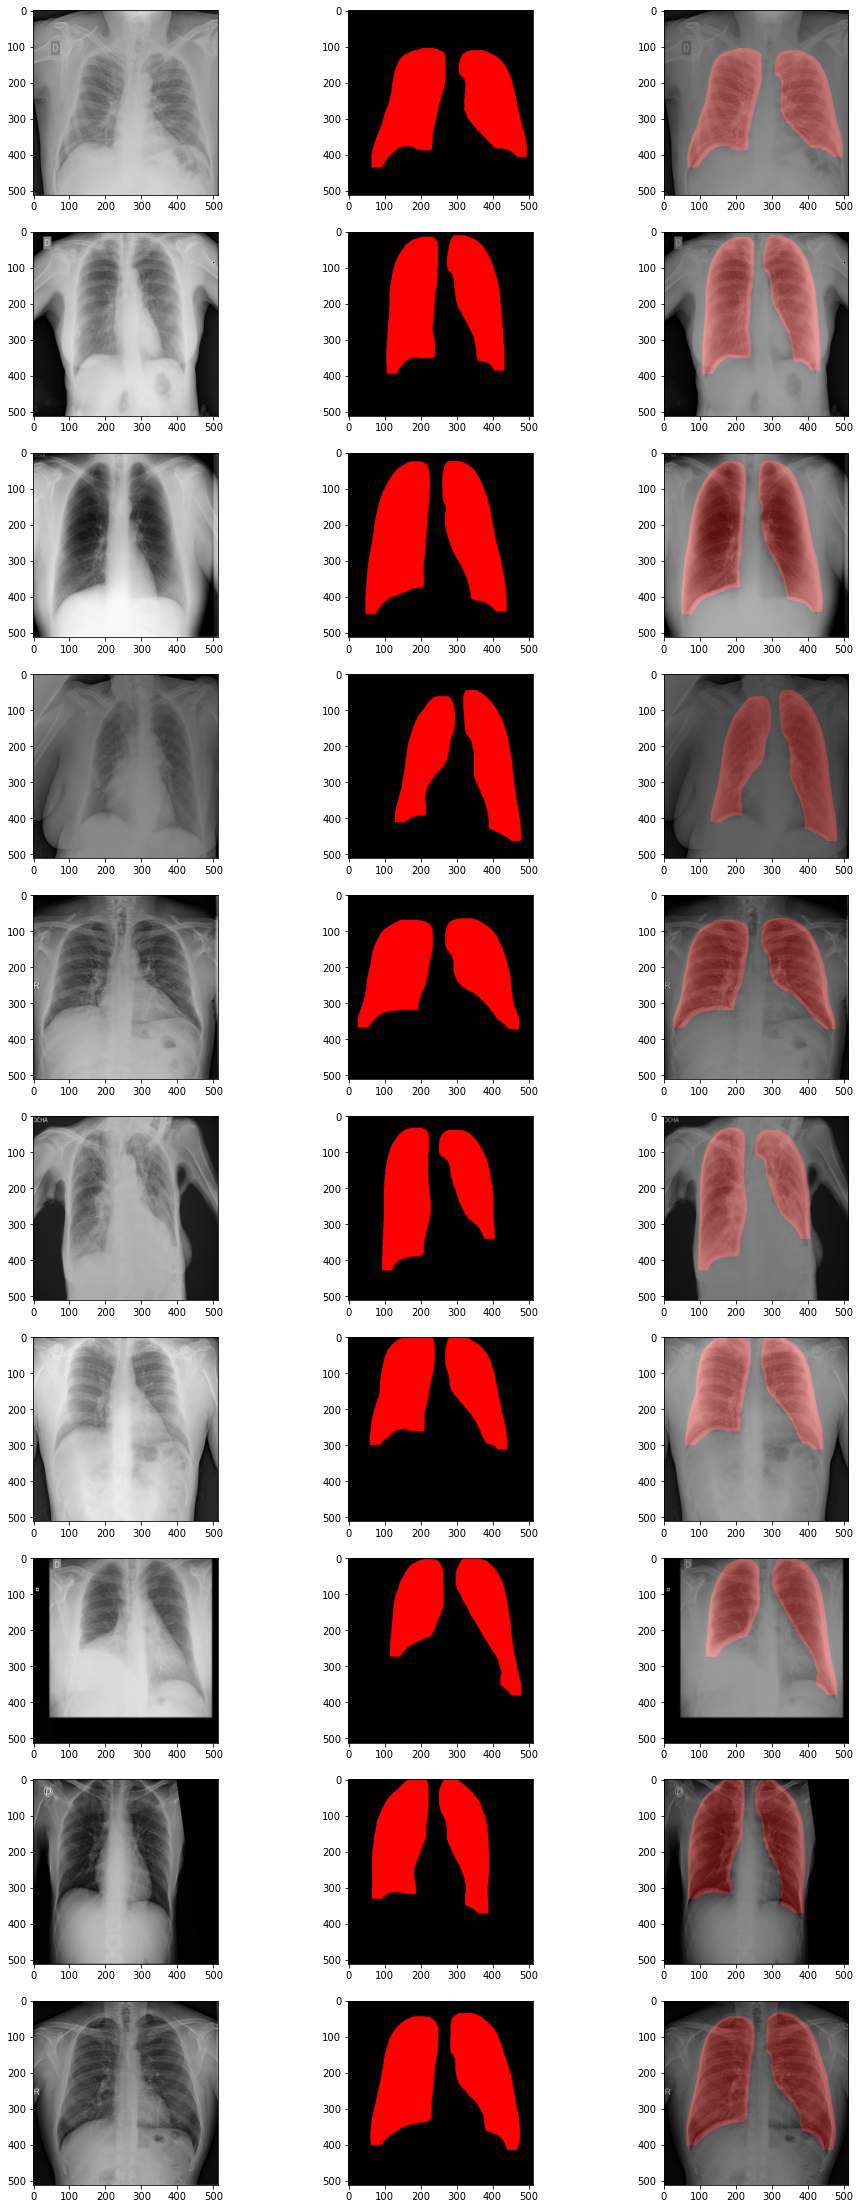

In [62]:
plt.figure(figsize=(16, 40))

for i in range(10):
    img = image[i]
    mask = np.zeros_like(img)
    mask[:,:,0] = pred[i][0]
    mask = morphology(mask)
    # red mask

    plt.subplot(10, 3, 1 + 3*i)
    plt.imshow(img)

    plt.subplot(10, 3, 2 + 3*i)
    plt.imshow(mask)

    plt.subplot(10, 3, 3 + 3*i)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.3)

plt.show()

In [93]:
hoge = pred[0][0]

In [94]:
hoge.shape

(512, 512)

In [96]:
np.concatenate([hoge, hoge]).shape

(512, 1024)